In [1]:
!pip install torch 

In [2]:
!pip install torchvision
!pip install trivial-torch-tools==0.4.1

In [3]:
import torch, torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

In [4]:
#training_transfroms = transforms.Compose([transforms.RandomResizedCrop(70), transforms.RandomRotation(45)])

training_data_num = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=None # training_transfroms
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



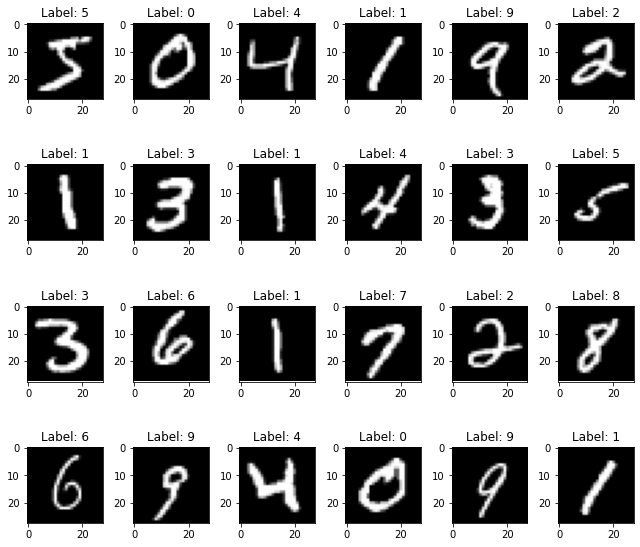

In [5]:
# picture = training_data[0][0]
# label = training_data[0][1]

# # print(label)
# # print(picture.size)

# picture

# for i in range (9):
#   picture = training_data[i][0]
#   label = training_data[i][1]
#   print(label, end='\n\n')
#   plt.subplot(330 + 1 + i)
#   plt.imshow(picture, cmap=plt.get_cmap('gray'))
#   plt.show()

num_row = 4
num_col = 6


# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(training_data_num[i][0], cmap='gray') # display picture
    ax.set_title('Label: {}'.format(training_data_num[i][1])) #display actual number of picture
plt.tight_layout()
plt.show()

In [ ]:
training_data_fash = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=None # training_transfroms
)

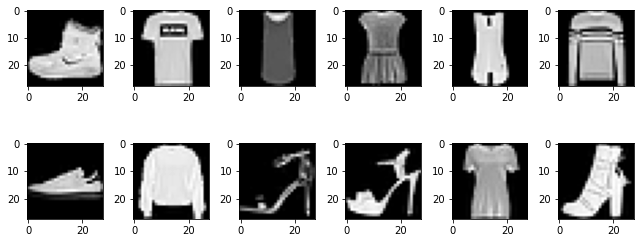

In [7]:
num_row = 2
num_col = 6


# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(training_data_fash[i][0], cmap='gray') # display picture
    #ax.set_title('Label: {}'.format(training_data[i][1])) #display actual number of picture
plt.tight_layout()
plt.show()

#Building the Network

Replace conv with fully connect

And train the fashion using similar network

In [8]:
import torch.nn.functional as F

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [12]:
from trivial_torch_tools import Sequential
from collections import OrderedDict
globals()["default_device"] = torch.device("cpu")
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [14]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [15]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [16]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [17]:
!mkdir -p ./results

In [18]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [19]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3103, Accuracy: 756/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325746
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.307569
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.300606
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.278439
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.289294
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.265428
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.251565
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.233512
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.204735
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.159272
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.160874
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.155896
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.991001
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.961050
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.892919
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.837494
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.606962
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.719905
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.556287
Train Epoch: 1 [12160/6

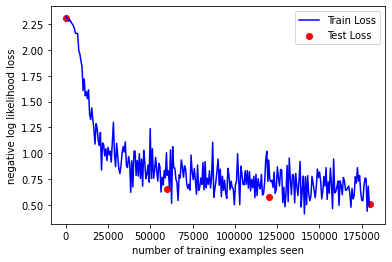

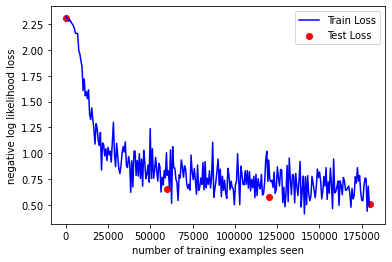

In [20]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig


In [21]:
print(len(test_counter))
print(len(test_losses))

4
4
